# Intro

This code generates the standard behavioral plots for one session.

In [7]:
##% imports
import pandas as pd
import matplotlib.pyplot as plt

from popy.io_tools import load_behavior
from popy.behavior_data_tools import *
from popy.plotting.plotting_tools import show_target_selection

# set fontsize to 8pt
plt.rcParams.update({'font.size': 8})

# Load data

The data should be in the 'standar' session data format: a pandas dataframe with 'trial_id', 'best_target', 'target' and 'feedback' columns.

Here is an example (you can load the raw data that I shared with you)

In [8]:
monkey, session = 'ka', '210322'

# load behav data
#session_data = load_behavior(monkey, session)  # load full dataset including all monkeys and sessions
session_data = pd.read_csv('/Users/zsombi/ZSOMBI/SBRI/PoPy/data/processed/behavior/local_run.csv')
session_data = convert_column_format(session_data, original='simulation')
session_data = drop_time_fields(session_data)  # drop time fields (not necessary for this plotting)
session_data = add_value_function(session_data, monkey='ka')  # add value function (it is an example to show how to plot some extra variables together with the behavior...)
session_data = add_phase_info(session_data)  # add phase info (it is an example to show how to plot some extra variables together with the behavior...)
session_data

,monkey,session,trial_id,block_id,target,feedback,best_target,value_function,phase
0,simulation,-1,0,0,1,1,2,NaN,NaN
1,simulation,-1,1,0,2,1,2,NaN,search
2,simulation,-1,2,0,3,0,2,NaN,search
3,simulation,-1,3,0,1,1,2,NaN,search
4,simulation,-1,4,0,1,0,2,NaN,search
...,...,...,...,...,...,...,...,...,...
152,simulation,-1,152,3,3,1,3,0.486429,repeat
153,simulation,-1,153,3,3,1,3,0.739279,repeat
154,simulation,-1,154,3,3,1,3,0.854968,repeat
155,simulation,-1,155,3,3,0,3,0.919323,repeat


# Plotting

This is how you can use this function: add the session data as the first argument, and the name of the subject as the second argument.

```python

In [9]:
from popy.plotting.plotting_tools import *

def show_target_selection_compact(
        session_data_original, 
        title=None, 
        background_value=None, 
        savedir=None, 
        show=True):
    """
    Generates a figure illustrating the target selection, feedback, and target value.

    Parameters
    ----------
    session_data_original : pandas.DataFrame
        The original session data. 
    title : str, optional
        The title of the figure. Default is None.
    background_value : str, optional
        The name of the column in the session data that contains the value to plot in the background. Default is None.
    savedir : str, optional
        The directory to save the figure. Default is None.
    show : bool, optional
        Whether to display the figure. Default is True.

    Returns
    -------
    None
    """
    # work on a copy of the original data
    session_data = session_data_original.copy()

    # set the colors of the targets in RGBA format
    target_colors = {1: '#90c6f2ff', 2: '#ffb273ff', 3: '#dea8ddff'}

    # add 'trial in session' column
    if 'trial_id_in_block' not in session_data.columns:
        session_data = add_trial_in_block(session_data)  # add 'trial in block' column
    
    # init plot
    cm_to_in = 0.393701
    n_rows = len(session_data['block_id'].unique())
    fig = plt.figure(figsize=(10*cm_to_in, 2.5*n_rows*cm_to_in))
    outer_grid = plt.GridSpec(n_rows, 1)  # Create the main grid for blocks

    for i in range(n_rows):
        # Create a subdivision of the block's grid space
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 1,
                                                    subplot_spec=outer_grid[i],
                                                    height_ratios=[1, 3],
                                                    hspace=0)
        
        # Create the two axes for this block
        ax_markers = plt.Subplot(fig, inner_grid[0])
        ax_measure = plt.Subplot(fig, inner_grid[1])
        fig.add_subplot(ax_markers)
        fig.add_subplot(ax_measure)

        # plot the target selection
        for target_id in [1, 2, 3]:  # plot the targets
            # get the selected target and its id, for REWARDED trials
            rewarded_trials_of_high_target = session_data.loc[
                (session_data['block_id'] == i) & (session_data['feedback'] == True) & (session_data['target'] == target_id) & (session_data['best_target'] == target_id)
                ]['trial_id_in_block']
            rewarded_trials_of_low_target = session_data.loc[
                (session_data['block_id'] == i) & (session_data['feedback'] == True) & (session_data['target'] == target_id) & (session_data['best_target'] != target_id)
                ]['trial_id_in_block']
            unrewarded_trials_of_high_target = session_data.loc[
                (session_data['block_id'] == i) & (session_data['feedback'] == False) & (session_data['target'] == target_id) & (session_data['best_target'] == target_id)
                ]['trial_id_in_block']
            unrewarded_trials_of_low_target = session_data.loc[
                (session_data['block_id'] == i) & (session_data['feedback'] == False) & (session_data['target'] == target_id) & (session_data['best_target'] != target_id)
                ]['trial_id_in_block']
            
            ax_markers.scatter(
                rewarded_trials_of_high_target,
                np.ones_like(rewarded_trials_of_high_target),
                color=target_colors[target_id], marker='o', facecolors=target_colors[target_id], s=12, linewidth=.6)  # plot rewarded trials
            ax_markers.scatter(
                rewarded_trials_of_low_target,
                np.ones_like(rewarded_trials_of_low_target),
                color=target_colors[target_id], marker='o', facecolors='none', s=12, linewidth=.6)  # plot rewarded trials
            ax_markers.scatter(
                unrewarded_trials_of_high_target,
                np.ones_like(unrewarded_trials_of_high_target),
                color=target_colors[target_id], marker='x', facecolors=target_colors[target_id], s=8, linewidths=1.4)
            ax_markers.scatter(
                unrewarded_trials_of_low_target,
                np.ones_like(unrewarded_trials_of_low_target),
                color=target_colors[target_id], marker='X', facecolors='none', s=12, linewidths=.6)
            
        # plot interrupted trials
        interrupted_trials_id = session_data.loc[
            (session_data['block_id'] == i) & (session_data['feedback'].isnull())
            ]['trial_id_in_block']

        if len(interrupted_trials_id) > 0:
            ax_markers.scatter(
                interrupted_trials_id,
                np.ones_like(interrupted_trials_id),
                color='black', marker='x', label='interrupted trial')
       
        '''# plot green lines marking the best target
        ax.plot(np.arange(0, no_of_trials, 1),
                np.ones((no_of_trials,)) * session_data.loc[session_data['block_id'] == i, 'best_target'],
                label='best target', color='green', alpha=.3, linewidth=20)'''

        # plot MEASURE (i.e. value)
        measure = session_data.loc[(session_data['block_id'] == i), background_value].to_numpy()
        ax_measure.plot(measure, color='grey', alpha=.6)  # plot the measure on the twin axis

        # mark last 5 trials per block (here the reward probabilities gradually change)
        no_of_trials = len(session_data.loc[session_data['block_id'] == i])  # number of trials in the block
        for ax in [ax_markers, ax_measure]:
            ax.axvline(no_of_trials - 6 + 0.5, linestyle='dashed', 
                        color='black', alpha=0.5)

        ## PLOT SETTINGS
        #ax_markers.title.set_text('block id: ' + str(i))

        ax_markers.set_xlim(-0.5, 45)
        ax_markers.set_ylim(0.8, 1.2)
        ax_markers.set_xticks(range(0, 45, 10))
        ax_markers.set_xticklabels([])
        ax_markers.set_yticks([])
        ax_markers.set_ylabel('')

        ax_measure.set_xlim(-0.5, 45)
        ax_measure.set_ylim(-.05, 1.05)

        if i == n_rows - 1:
            ax_measure.set_xlabel('trials in block (trials in session)')
        ax_measure.set_ylabel(background_value)

        # set xticks to trial ids
        trial_ids = session_data.loc[session_data['block_id'] == i, 'trial_id'].values
        xticks = []
        for x in range(0, 45, 10):
            if x < len(trial_ids):
                xticks.append(f'{str(x+1)} ({str(trial_ids[x]+1)})')
            else:
                xticks.append(str(x+1))
        ax_measure.set_xticks(range(0, 45, 10))
        ax_measure.set_xticklabels(xticks)

        # remove spines
        ax_markers.spines['top'].set_visible(False)
        ax_markers.spines['right'].set_visible(False)
        ax_markers.spines['bottom'].set_visible(False)

        ax_measure.spines['top'].set_visible(False)
        ax_measure.spines['right'].set_visible(False)
        ax_measure.spines['bottom'].set_visible(False)

        ax_measure.axhline(0, color='grey', linewidth=0.5, linestyle='dashed')
        ax_measure.axhline(1, color='grey', linewidth=0.5, linestyle='dashed')

        '''ax_measure.grid()
        ax_markers.grid()'''

    # add legend to last subplot, below in the middle
    ax_markers.scatter([], [], color='grey', marker='o', facecolors='grey', s=30, label='Rewarded - HIGH target')
    ax_markers.scatter([], [], color='grey', marker='o', facecolors='none', s=30, label='Rewarded - LOW target')
    ax_markers.scatter([], [], color='grey', marker='X', facecolors='grey', s=30, label='Unrewarded - HIGH target')
    ax_markers.scatter([], [], color='grey', marker='X', facecolors='none', s=30, label='Unrewarded - LOW target')
    ax_markers.legend(loc='center', bbox_to_anchor=(.5, -8), ncol=2)

    plt.tight_layout()
    if title is not None:
        plt.suptitle(title, y=1)

    if savedir is not None:
        plt.savefig(savedir, dpi=300, bbox_inches='tight', transparent=True)
    if show:
        plt.show()
    else:
        plt.close()


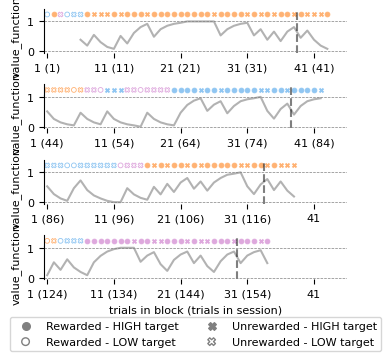

In [10]:
# target selection
savedir = os.path.join('figs', 'example_session_compact.svg')
show_target_selection_compact(session_data_original = session_data, 
                      background_value='value_function',   # here we tell what variable to use as background - value in this case
                      title=None, #f'monkey: {monkey}, session: {session}', 
                      show=True, 
                      savedir=savedir)